In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.notebook import tqdm

from typing import List

import pickle

from autoencoder import Autoencoder

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Kludge for errors with graph generation
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

cuda


In [38]:
# Create a dataset/dataloader for the triples

class LossDataset(Dataset):
    def __init__(self, pkl_path):
        """
        Args:
            pkl_path (str): Path to .pkl file containing loss data (in the form of (params, acc, loss) tuples)
        """
        with open(pkl_path, "rb") as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            x, _, y = self.data[idx]
            return x.detach().cpu(), y
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise
    
model_name = "mini_cnn"
    
dataset = LossDataset(f"./data/loss_samples/{model_name}/loss_samples.pkl")

train_frac = 0.8
n_total = len(dataset)
n_train = int(train_frac * n_total)
n_test = n_total - n_train

generator = torch.Generator().manual_seed(42)  # reproducible split

train_dataset, test_dataset = random_split(
    dataset,
    [n_train, n_test],
    generator=generator
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True
)


Landscape Distance Loss:
$$\mathcal{L}_{Geometric} = \frac{1}{n^2}\sum_{i,j} (||q(x_i)-q(x_j)||_2 - ||(x_i,L(x_i))-(x_j,L(x_j))||_2)^2$$

In [39]:
def landscape_dist_loss(Q, X, L):
    """
    Q: Embeddings
    X: Parameters
    L: Loss
    """

    # Z = (X, L)
    Z = torch.cat([X, torch.unsqueeze(L, dim=1)], dim=1)

    # Pairwise dists
    Dq = torch.cdist(Q, Q, p=2)
    Dz = torch.cdist(Z, Z, p=2)

    # Total dists
    loss = (Dq - Dz).pow(2).mean()

    return loss

In [40]:
def train_autoencoder(model, train_loader, test_loader, optimizer, num_epochs, loss_type: str, lambda_geometric, device):

    model.train()

    loss_fn = nn.MSELoss()

    history = {
        "train_loss": [],
        "train_recon_loss": [],
        "train_geometric_loss": [],
        "test_loss": [],
        "test_recon_loss": [],
        "test_geometric_loss": [],
    }

    for epoch in tqdm(range(num_epochs)):

        train_loss_total, train_recon_loss_total, train_geometric_loss_total = 0.0, 0.0, 0.0
        test_loss_total, test_recon_loss_total, test_geometric_loss_total = 0.0, 0.0, 0.0

        for params, loss_vals in train_loader:

            params, loss_vals = params.to(device), loss_vals.to(device)

            optimizer.zero_grad()

            embeddings = model.encode(params)
            reconstructions = model.decode(embeddings)

            recon_loss = loss_fn(reconstructions, params)

            if loss_type == "landscape_dist":
                geometric_loss = landscape_dist_loss(embeddings, params, loss_vals)
            elif loss_type == "smooth_preserving":
                pass
            else:
                raise Exception

            loss = recon_loss + geometric_loss*lambda_geometric
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            train_recon_loss_total += recon_loss.item()
            train_geometric_loss_total += geometric_loss.item()

        with torch.no_grad():

            for params, loss_vals in test_loader:

                params, loss_vals = params.to(device), loss_vals.to(device)

                embeddings = model.encode(params)
                reconstructions = model.decode(embeddings)

                recon_loss = loss_fn(reconstructions, params)

                if loss_type == "landscape_dist":
                    geometric_loss = landscape_dist_loss(embeddings, params, loss_vals)
                elif loss_type == "smooth_preserving":
                    pass
                else:
                    raise Exception

                loss = recon_loss + geometric_loss*lambda_geometric

                test_loss_total += loss.item()
                test_recon_loss_total += recon_loss.item()
                test_geometric_loss_total += geometric_loss.item()

        print(f"[Epoch {epoch}]\tTrain loss: {train_loss_total:.6f}\tRecon Loss: {train_recon_loss_total:.6f}\tGeometric Loss: {train_geometric_loss_total:.6f}")
        history["train_loss"].append(train_loss_total)
        history["train_recon_loss"].append(train_recon_loss_total)
        history["train_geometric_loss"].append(train_geometric_loss_total)
        history["test_loss"].append(test_loss_total)
        history["test_recon_loss"].append(test_recon_loss_total)
        history["test_geometric_loss"].append(test_geometric_loss_total)

    return history

In [41]:
# Get dimension of the parameters
input_dim = 0
for params, losses in train_loader:
    input_dim = params.shape[1]
    break

geometric_autoencoder = Autoencoder(
    input_dim=input_dim,
    latent_dim=128,
    hidden_dims=[256]
).to(device)

optimizer = torch.optim.AdamW(geometric_autoencoder.parameters())

loss_type = "landscape_dist"

history = train_autoencoder(
    model=geometric_autoencoder, 
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer, 
    num_epochs=50, 
    loss_type=loss_type, 
    lambda_geometric=0.1,
    device=device,
)

torch.save(geometric_autoencoder.state_dict(), f'models/ae_{model_name}_{loss_type}_loss.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 0]	Train loss: 27.450110	Recon Loss: 0.026971	Geometric Loss: 274.231384
[Epoch 1]	Train loss: 13.492862	Recon Loss: 0.025130	Geometric Loss: 134.677319
[Epoch 2]	Train loss: 3.758067	Recon Loss: 0.021460	Geometric Loss: 37.366065
[Epoch 3]	Train loss: 0.774350	Recon Loss: 0.019993	Geometric Loss: 7.543571
[Epoch 4]	Train loss: 2.863256	Recon Loss: 0.017538	Geometric Loss: 28.457180
[Epoch 5]	Train loss: 3.036830	Recon Loss: 0.016102	Geometric Loss: 30.207271
[Epoch 6]	Train loss: 0.918509	Recon Loss: 0.015628	Geometric Loss: 9.028813
[Epoch 7]	Train loss: 0.448480	Recon Loss: 0.014602	Geometric Loss: 4.338786
[Epoch 8]	Train loss: 0.750164	Recon Loss: 0.013354	Geometric Loss: 7.368098
[Epoch 9]	Train loss: 0.660187	Recon Loss: 0.012170	Geometric Loss: 6.480173
[Epoch 10]	Train loss: 0.366460	Recon Loss: 0.011233	Geometric Loss: 3.552270
[Epoch 11]	Train loss: 0.262888	Recon Loss: 0.010620	Geometric Loss: 2.522682
[Epoch 12]	Train loss: 0.245225	Recon Loss: 0.010063	Geometric Lo

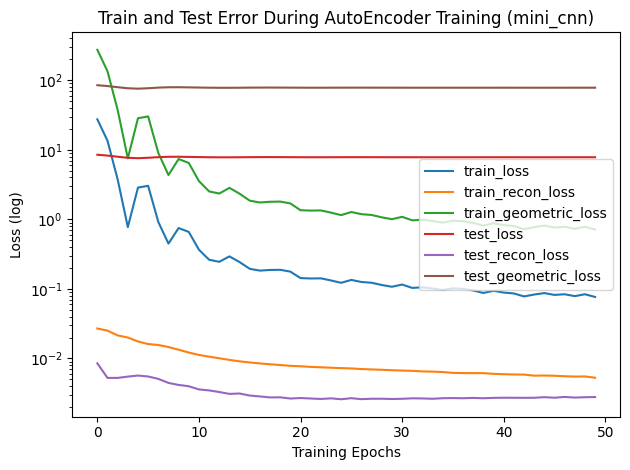

In [42]:
x = [i for i in range(50)]

plt.figure()
for key, values in history.items():
    plt.plot(x, values, label=key)

plt.xlabel("Training Epochs")
plt.ylabel("Loss (log)")
plt.yscale('log')
plt.legend()
plt.title(f"Train and Test Error During AutoEncoder Training ({model_name})")
plt.tight_layout()
plt.show()

In [43]:
print(history)
print(len(history["train_loss"]))

{'train_loss': [27.450109778513244, 13.492861661719301, 3.75806671189879, 0.7743499767247892, 2.8632555291570236, 3.036829506880067, 0.9185091945534201, 0.44848012569720663, 0.7501639348264852, 0.6601874565836392, 0.3664603381554148, 0.2628878142942578, 0.2452251155313066, 0.293420505268447, 0.243172339967128, 0.1945570141066523, 0.18328458066593728, 0.1873632302361295, 0.18827287321291925, 0.17735662061132795, 0.1430648128764096, 0.14129116137691028, 0.14192266760584066, 0.13237378583482318, 0.12237957200869899, 0.13470167178350134, 0.1257663749935164, 0.12266915238706076, 0.11382039654428966, 0.10738879954617035, 0.11552609445020665, 0.10343420232833336, 0.10543378290962341, 0.10127739024183006, 0.09622523570422473, 0.10179809915373497, 0.10018540688977406, 0.09487231033384604, 0.08745291308729244, 0.09404368069495944, 0.08860683529785654, 0.08612021926912922, 0.07802016408121182, 0.08299268083734332, 0.08712379245910717, 0.08198676924612666, 0.08377766557862343, 0.07875435095016683,